In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';').drop(columns='Unnamed: 0')
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


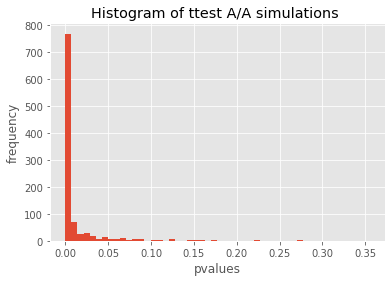

0.932

In [26]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 0")['purchase'].sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 1")['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [ ]:
# Проведя А/А-тестирование, видим, что наш FPR равняется аж 0.932, то есть 93.2% сравнений стат. значимо различаются (ложно-положительны).
# Такого быть не должно при правильном функционировании системы сплитования, ведь мы просто разделили пользователей на 2 группы.
# Никаких изменений мы не вводили, потому и FPR должен быть в идеале меньше 0.05 при альфе 0.05.

In [28]:
df \
    .groupby(['experimentVariant', 'version']) \
    .agg({'purchase': 'mean'}) \
    .rename(columns={'purchase': 'conversion'})

conversion
experimentVariant version             
0                 v2.8.0      0.000993
                  v2.9.0      0.074658
                  v3.7.4.0    0.059943
                  v3.8.0.0    0.057604
1                 v2.8.0      0.045606
                  v2.9.0      0.071304
                  v3.7.4.0    0.063018
                  v3.8.0.0    0.062848

In [ ]:
# Сгруппировав наши наблюдения по двум группам и версиям МП, вычислим конверсию в покупку для каждой группы.
# Сравнив конверсии, видим сильные различия (на порядки) у версии 2.8.0. Однако всё равно надо провести t-тест
# для всех версий приложений в каждой группе, т.к. на глаз сравнивать - опасно.

In [38]:
print('p - уровень значимости версии 2.8.0:   ', \
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v2.8.0'")['purchase'].values,
                df.query("experimentVariant == 1 and version == 'v2.8.0'")['purchase'].values,
                equal_var = False)[1])
print('p - уровень значимости версии 2.9.0:   ', \
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v2.9.0'")['purchase'].values,
                df.query("experimentVariant == 1 and version == 'v2.9.0'")['purchase'].values,
                equal_var = False)[1])
print('p - уровень значимости версии 3.7.4.0: ', \
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v3.7.4.0'")['purchase'].values,
                df.query("experimentVariant == 1 and version == 'v3.7.4.0'")['purchase'].values,
                equal_var = False)[1])
print('p - уровень значимости версии 3.8.0.0: ', \
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v3.8.0.0'")['purchase'].values,
                df.query("experimentVariant == 1 and version == 'v3.8.0.0'")['purchase'].values,
                equal_var = False)[1])

p - уровень значимости версии 2.8.0:    0.0
p - уровень значимости версии 2.9.0:    0.31835686930247525
p - уровень значимости версии 3.7.4.0:  0.5568700784122844
p - уровень значимости версии 3.8.0.0:  0.2311993431794881


In [ ]:
# Наши опасения подтвердились, и мы видим стат. значимые различия именно у нашего подозреваемого - версии 2.8.0.
# У остальных t-тест не нашёл стат. значимых различий (p - ур. значимости > 0.05).
# Попробуем исключить версию 2.8.0 из наших выборок и проведём новое А/А-тестирование.

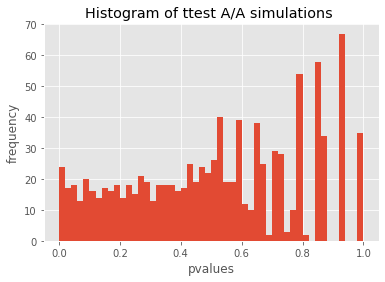

0.054

In [29]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 0 and version != 'v2.8.0'")['purchase'].sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 1 and version != 'v2.8.0'")['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [ ]:
# Теперь FPR равен 0.054, то есть 5.4% сравнений наших наблюдений из двух групп дали ложно-положительный результат,
# что абсолютно нормально (при альфе 0.05). К тому же распределение p - ур. значимости напоминает плюс-минус равномерное.
# Такой результат стал возможен благодаря тому, что теперь наши две группы репрезентативны (0 и 1), поскольку из сравнения
# мы исключили версию 2.8.0, у который был совершенно разный показатель конверсии в 0 и 1 группах.
# Что могло стать причиной такой разной конверсии? Система сплитования плохо разделила наших пользователей именно по этой
# версси МП, здесь уже вопросы к разработчикам скрипта. Устранив недостаток в скрипте, можно будет заново включить
# данную версию в наши группы и, если конверсии в поряке, запустить повторное А/А-тестирование.